In [3]:
import numpy as np
import pandas as pd

In [7]:
df_perms = {}

for i in range(1, 23):
    df_perms[i] = pd.read_csv(f"{i}_permutation_data_1000.tsv", sep="\t")


In [8]:
#df_perms[1]

In [9]:
# Note that the row number is the annotation, so df_perms[i][k] is annotation annotation[k] in chromosome i
annotations = ['3_prime_UTR_variant','5_prime_UTR_variant','NMD_transcript_variant','coding_sequence_variant','downstream_gene_variant','incomplete_terminal_codon_variant','intergenic_variant','intron_variant','mature_miRNA_variant','missense_variant','non_coding_transcript_exon_variant','non_coding_transcript_variant','splice_acceptor_variant','splice_donor_variant','splice_region_variant','start_lost','stop_gained','stop_lost','stop_retained_variant','synonymous_variant','upstream_gene_variant']

for i in range(1, 23):
    df_perms[i].set_axis(annotations, axis=0, inplace=True)



In [10]:
# df_perms.items()

In [11]:
np_perms = {}

for i in range(1,23):
    np_perms[i] = df_perms[i].to_numpy()[:,0:]


In [12]:
# Count the number of sign SNPs in each annotation, that are greater than the original nr

np_original = {}
np_location = {}
np_original_loc = {}
a_matrix = {} # the locations of original annotations

for i in range(1, 23):
    np_original[i] = pd.read_csv(f"{i}permutationready.tsv", sep="\t").to_numpy()
    np_location[i] = np_original[i][::,1] # the ordinal location of significant SNPs
    np_original_loc[i] = np_original[i][:,2:] # the ordinal locations of different annotations 
                                                # (the columns are annotations)
    a_matrix[i] = np_original_loc[i].transpose()

In [13]:
signsum = np.zeros(22) # the total number of significant SNPs per chromosome

for i in range(1,23):
    signsum[i-1] = np.sum(np_original[i][:,1])
    

In [14]:
# original number of sign snps per annotation per chrom

original_number = {}

for i in range(1,23):
    original_number[i] = np.matmul(a_matrix[i],np_location[i])


In [15]:
from collections import Counter

dict_counter = {} # for all chromosomes

for i in range(1,23):
    
    dict_counter[i] = {} # dict_counter[i] is the counts for chromosome i

    for j in range(0,21):
            dict_counter[i][j] = Counter(np_perms[i][j,::]) # j is the annotation[j]
            

In [17]:
# calculating enrichment
e_matrix = np.zeros((22,21))

for i in range(0,22):
# each row is the count nr in the corresponding chromosome n-1 (so row 0 corresponds to chrom 1)
    for k in range(0,21): # k is the annotation nr
        for l in dict_counter[i+1][k]: # l is number of sign SNP in annotation
            if l >= original_number[i+1][k]: # and original_number[i+1][k] != 0: 
                e_matrix[i][k] = e_matrix[i][k] + dict_counter[i+1][k][l] # freq_matrix[i+1][k][l] 
                                                                              # is nr of counts of l sign SNP 
                                                                              # in annotation
                        
p_vals_e = e_matrix/1000

# Note: p_vals_e[i][j] is the enrichment of annotation j+1 in chromosome i+1

# calculating depletion
d_matrix = np.zeros((22,21))

for i in range(0,22):
# each row is the count nr in the corresponding chromosome n-1 (so row 0 corresponds to chrom 1)
    for k in range(0,21): # k is the annotation nr
        for l in dict_counter[i+1][k]: # l is number of sign SNP in annotation
            if l <= original_number[i+1][k]: # and original_number[i+1][k] != 0: 
                d_matrix[i][k] = d_matrix[i][k] + dict_counter[i+1][k][l] # freq_matrix[i+1][k][l] 
                                                                              # is nr of counts of l sign SNP 
                                                                              # in annotation
                        
p_vals_d = d_matrix/1000

# Note: p_vals_e[i][j] is the enrichment of annotation j+1 in chromosome i+1

In [18]:
# calculate odds ratio (like what Alida did)


In [19]:
# Calculate total nr of SNPs per chromosome
all_snps = np.zeros(22)
for i in range(22):
    all_snps[i] = (np.shape(np_original[i+1])[0])
    
print(all_snps)

[ 948317. 1030243.  870283.  878477.  792479.  807681.  711559.  679865.
  530103.  615661.  608395.  572274.  432288.  389047.  342440.  382762.
  327510.  339309.  278584.  269395.  161590.  162893.]


In [20]:
# Calculate total nr of sSNPs per chromosome
sign_snps = np.zeros(22)

for i in range(22):
    sign_snps[i] = (np.sum(np_location[i+1][np_location[i+1]==1]))
    
print(sign_snps)

[255. 200. 191. 133. 228. 200. 174. 457.  47. 227. 332. 209.  28.  30.
 101. 164. 141.  50.  87. 134.  21.  11.]


In [21]:
# nr of overlaps OBSERVED == original_number[i][k] for annotation[k] {# overlaps O}

overlaps_o = {}

for i in range(1,23):
    overlaps_o[i] = original_number[i]

# nr of non-overlaps OBSERVED for each annotation {# non overlaps O}

non_overlaps_o = {}

for i in range(1,23):
    non_overlaps_o[i] = np.full((21),sign_snps[i-1]) - original_number[i]


255.0

In [22]:
# nr of overlaps EXPECTED for each annotation {# overlaps E}

overlaps_e = {}

for i in range(1,23):
    
    overlaps_e[i] = np.zeros(21)

    for k in range(21):
        
        overlaps_e[i][k] = np.dot((np.array(list(dict_counter[i][k].keys()))), (np.array(list(dict_counter[i][k].values()))))/100000

# nr of non-overlaps EXPECTED for each annotation {# non overlaps E}

non_overlaps_e = {}

for i in range(1,23):
    non_overlaps_e[i] = np.full((21),sign_snps[i-1]) - overlaps_e[i]


In [23]:
# calculate odds ratio

# OR = (# overlaps O)(# non overlaps E)/(# non overlaps O)(# overlaps E)

odds_ratio = {} # odd_ratio[i] is the odds ratio for chromosome i for all annotations

for i in range(1,23):
    odds_ratio[i] = np.zeros(21)
    for k in range(21):
        if non_overlaps_o[i][k]*overlaps_e[i][k] != 0:
            odds_ratio[i][k] = ((overlaps_o[i][k])*non_overlaps_e[i][k])/((non_overlaps_o[i][k]*overlaps_e[i][k]))
        else:
            odds_ratio[i][k] = np.nan

In [24]:
odds_ratio[1]

array([232.26591196, 480.39641286,  73.40466923,   0.        ,
       190.47320412,   0.        ,  72.87028742, 310.30512327,
         0.        ,  93.18922475, 120.07759376, 222.07422495,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  98.80691964,
       206.47849082])

In [25]:
# PLOT HEATMAP

# first we calculate the pvals -- an annotation cannot be enriched and depleted at the same time. 

In [26]:
# PLOT FIGURES (with 2 pvals and OR)

In [27]:
import seaborn as sns


In [28]:
# load package
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator

In [29]:
a = list(mpl.rcParams.keys())
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [30]:
#['3_prime_UTR_variant','5_prime_UTR_variant','NMD_transcript_variant','coding_sequence_variant','downstream_gene_variant','incomplete_terminal_codon_variant','intergenic_variant','intron_variant','mature_miRNA_variant','missense_variant','non_coding_transcript_exon_variant','non_coding_transcript_variant','splice_acceptor_variant','splice_donor_variant','splice_region_variant','start_lost','stop_gained','stop_lost','stop_retained_variant','synonymous_variant','upstream_gene_variant']


In [33]:
p_vals_e

array([[0.042, 0.002, 0.744, 1.   , 0.032, 1.   , 0.989, 0.076, 1.   ,
        0.584, 0.371, 0.048, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 0.581, 0.01 ],
       [0.647, 0.43 , 0.275, 1.   , 0.001, 1.   , 1.   , 0.022, 1.   ,
        0.865, 0.457, 0.015, 1.   , 0.033, 0.427, 1.   , 1.   , 1.   ,
        1.   , 1.   , 0.077],
       [0.22 , 0.174, 0.465, 1.   , 0.161, 1.   , 0.992, 0.107, 1.   ,
        0.566, 0.779, 0.414, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 0.066, 0.006],
       [0.043, 0.264, 0.051, 1.   , 0.22 , 1.   , 0.891, 0.19 , 1.   ,
        0.005, 0.186, 0.224, 1.   , 1.   , 1.   , 1.   , 0.016, 1.   ,
        1.   , 1.   , 0.066],
       [0.118, 0.453, 0.54 , 1.   , 0.345, 1.   , 0.61 , 0.406, 1.   ,
        0.843, 0.482, 0.237, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 1.   , 0.396],
       [0.432, 1.   , 0.978, 1.   , 0.139, 1.   , 0.705, 0.402, 1.   ,
        1.   , 0.751, 0.813, 1.   , 1.   , 0.372, 1.   , 1.   , 1.   

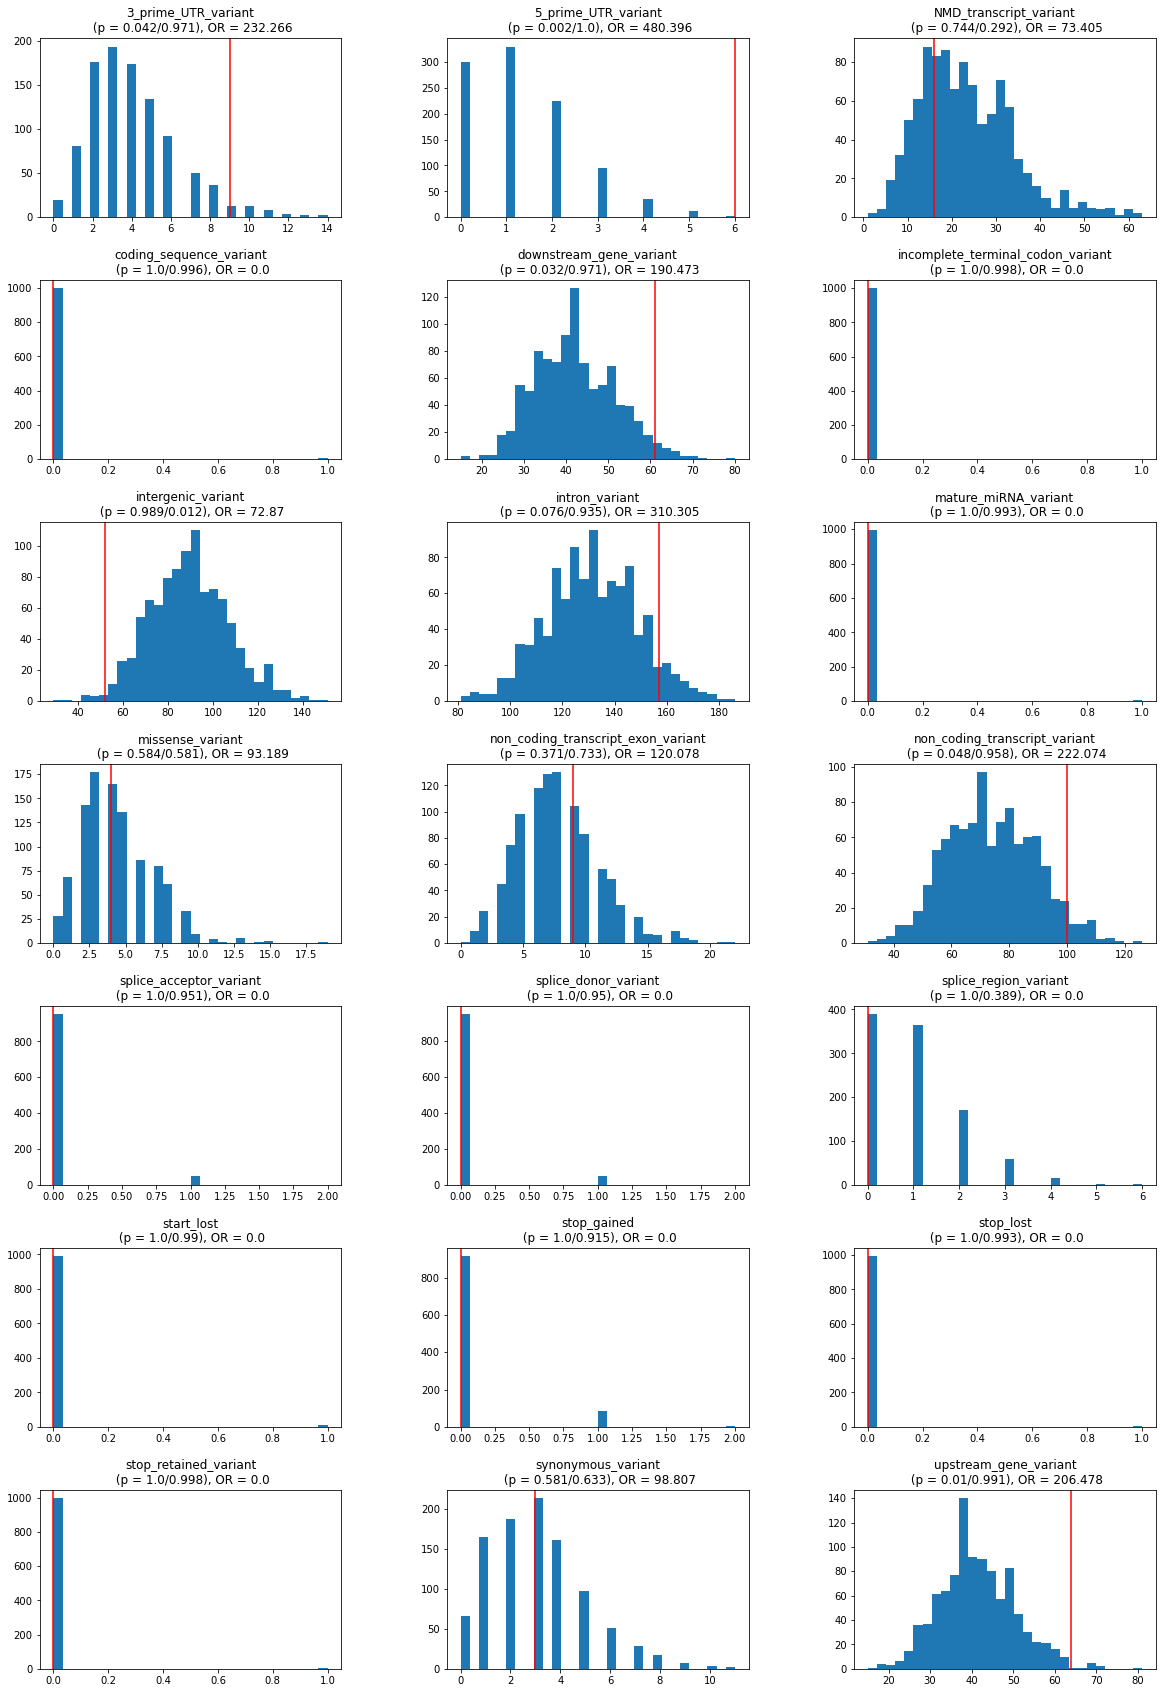

In [36]:
fig,axs = plt.subplots(nrows=7,ncols=3,figsize=(20,30),gridspec_kw={'wspace':0.35,'hspace':0.35})
i = 1 # chromosome
l = -1
for j in range(0,7):
    for k in range(0,3):
        l = l+1
        axs[j,k].hist(np_perms[i][l,::], bins=30)
        axs[j,k].set_title(str(annotations[l]) + "\n" + " (p = " + str(np.around(p_vals_e[i-1][l], decimals=3)) + "/" + str(np.around(p_vals_d[i-1][l], decimals=3)) + "), OR = " + str(np.around(odds_ratio[i][l], decimals=3)))
        axs[j,k].axvline(x=original_number[i][l], color='r', label= 'observed number' )

#fig.text(0.5, 0.04, 'common xlabel', ha='center', va='center', fontsize = 20)
#fig.text(0.06, 0.5, 'common ylabel', ha='center', va='center', rotation='vertical', fontsize=20)
#for ax in axs.flat:
   # ax.set(xlabel='Number of significant SNPs', ylabel='Frequency')

plt.savefig("chrom" +str(i)+ "_all")